<a href="https://colab.research.google.com/github/parfait2/2022-birthmark/blob/main/%EC%82%B0%ED%95%99%ED%98%91%EB%A0%A5%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_220729.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import sys

def get_contour_list(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    high_thresh, thresh_im = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    lowThresh = 0.5 * high_thresh
    edged = cv2.Canny(img_gray, lowThresh, high_thresh)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
    closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = []
    for contour in contours:
        x_length, y_length = (np.max(contour, axis=0) - np.min(contour, axis=0))[0]
        if cv2.contourArea(contour) > ((x_length) * (y_length)) / 2:
            filtered_contours.append(contour)

    return filtered_contours

def get_center_list(contour_list):
    center_list = []
    for contour in contour_list:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            center_list.append((cx, cy))

    return center_list

In [ ]:
time_1_file = "image2.png"
time_2_file = "image2-time2.png"

time_1_image = cv2.imread(time_1_file)
time_2_image = cv2.imread(time_2_file)
time_2_image_center = np.array(time_2_image.shape[1::-1]) / 2

time_1_contour_list = get_contour_list(time_1_image)
time_2_contour_list = get_contour_list(time_2_image)

time_1_center_list = get_center_list(time_1_contour_list)
time_2_center_list = get_center_list(time_2_contour_list)

In [ ]:
def rotate_points(points, center_loc, degree):
    rad = np.radians(degree)
    c, s = np.cos(rad), np.sin(rad)
    rotate_matrix = np.array(((c, -s), (s, c)))
    rotated_points = (points - np.array(center_loc)).dot(rotate_matrix) + center_loc

    return rotated_points

def calculate_distance(org_loc_list, new_loc_list):
    total_dist = 0
    for idx, loc in enumerate(np.array(org_loc_list)):
        # 가장 가까운 점과의 거리 계산
        smallest_dist = sys.maxsize
        for target_loc in np.array(new_loc_list):
            dist = np.linalg.norm(target_loc - loc)
            if dist < smallest_dist:
                smallest_dist = dist
        total_dist += smallest_dist

    return total_dist

In [ ]:
def f(params, center_list_1, center_list_2, time_2_image_center):
    x_diff, y_diff, degree, expand_ratio = params

    center_list_1 = np.array(center_list_1)
    center_list_2 = np.array(center_list_2)

    modified_center_list = np.array(center_list_2)
    # 회전
    modified_center_list = rotate_points(modified_center_list, time_2_image_center, degree)
    # 확대, 축소
    modified_center_list = modified_center_list * expand_ratio
    # X, Y 오프셋
    modified_center_list = modified_center_list + [x_diff, y_diff]

    # 거리 계산
    distance = calculate_distance(center_list_1, modified_center_list)

    return distance

In [ ]:
# 'Nelder-Mead', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 'trust-constr'
# 어느 정도 좋은 성능을 보인 method - Powell, trust-constr
for method in ['Powell']:
    print(method)
    result = scipy.optimize.minimize(f, [0, 0, 0, 1], method=method, args=(time_1_center_list, time_2_center_list, time_2_image_center))

    print("total_distance_diff:", f"{result.fun:0.2f}")

    x_diff, y_diff, degree, expand_ratio = result.x
    print("x_diff:", int(x_diff))
    print("y_diff:", int(y_diff))
    print("rotation:", int(degree))
    print("expand_ratio:", f"{expand_ratio:0.2f}")

Powell
total_distance_diff: 1025.87
x_diff: 38
y_diff: 22
rotation: 4
expand_ratio: 0.84


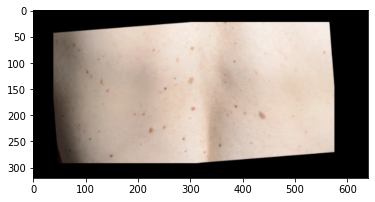

In [ ]:
def rotate_image(image, image_center, degree):
    rot_mat = cv2.getRotationMatrix2D(image_center, degree, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)

    return result

def resize_image(image, expand_ratio):
    h, w = image.shape[:2]
    resized_image = cv2.resize(image, None, fx=expand_ratio, fy=expand_ratio)
    resized_h, resized_w = resized_image.shape[:2]

    result = np.zeros((h, w, 3), np.uint8)
    result[0:resized_h, 0:resized_w] = resized_image[0:h, 0:w]

    return result

def shift_image(image, x_shift, y_shift):
    h, w = image.shape[:2]
    shift_mat = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
    result = cv2.warpAffine(image, shift_mat, (w, h))

    return result

rotated_image = rotate_image(time_2_image, time_2_image_center, degree)
resized_image = resize_image(rotated_image, expand_ratio)
shifted_image = shift_image(resized_image, x_diff, y_diff)

plt.imshow(cv2.cvtColor(shifted_image, cv2.COLOR_BGR2RGB))

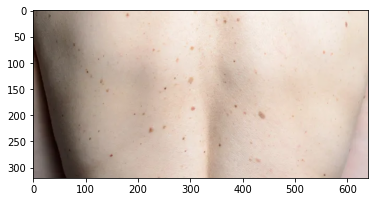

In [ ]:
plt.imshow(cv2.cvtColor(time_1_image, cv2.COLOR_BGR2RGB))

In [ ]:
def rotate_contours(contours, center_loc, degree):
    rad = np.radians(degree)
    c, s = np.cos(rad), np.sin(rad)
    rotate_matrix = np.array(((c, -s), (s, c)))
    rotated_points = np.array([(contour - np.array(center_loc)).dot(rotate_matrix) + center_loc for contour in contours], dtype=object)

    return rotated_points

def transform_contours(contour_list, center_loc, x_diff, y_diff, degree, expand_ratio):
    # 회전
    modified_contour_list = rotate_contours(contour_list, center_loc, degree)
    # 확대, 축소
    modified_contour_list = modified_contour_list * expand_ratio
    # X, Y 오프셋
    modified_contour_list = [contour + [x_diff, y_diff] for contour in modified_contour_list]
    # int로 변환
    modified_contour_list = [contour.astype(int) for contour in modified_contour_list]

    return modified_contour_list

In [ ]:
transformed_contour_list = transform_contours(time_2_contour_list, time_2_image_center, x_diff, y_diff, degree, expand_ratio)

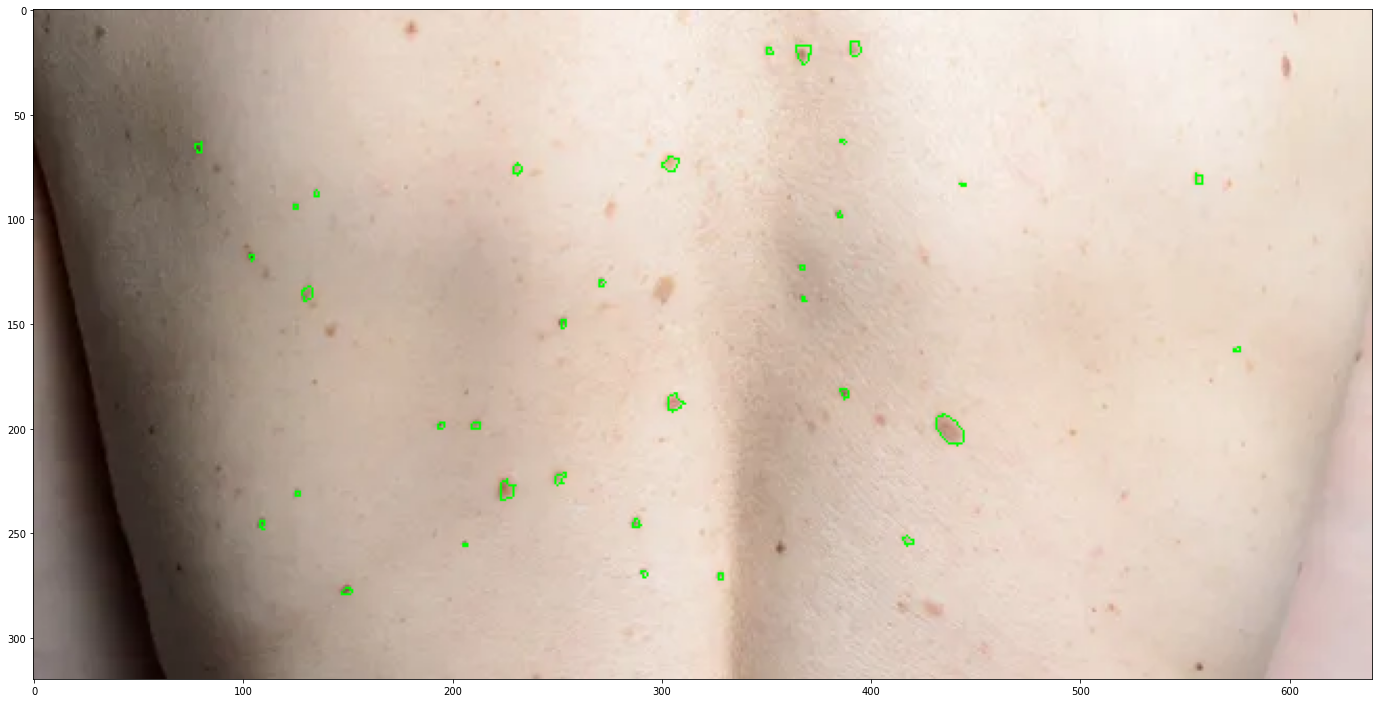

In [ ]:
plt.figure(figsize=(24, 24))
contours_img = cv2.drawContours(time_1_image, transformed_contour_list, -1, (0, 255, 0), 1)
plt.imshow(cv2.cvtColor(contours_img, cv2.COLOR_BGR2RGB))